# COMP47590: Advanced Machine Learning
# Assignment 1: Building Heterogenous Ensembles

- Student 1 Name: Finola Cahill
- Student 1 Number: 07645074

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LinearRegression as LR
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn.utils.multiclass import unique_labels
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import metrics
from sklearn.base import is_classifier
from sklearn.utils import resample
from sklearn.base import clone
from sklearn.datasets import load_iris
import itertools
from itertools import chain, combinations
import random
from copy import copy
import collections
from sklearn.metrics import recall_score
import matplotlib.patches as mpatches
from statistics import mean
from keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, brier_score_loss
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_validate, KFold
from sklearn import preprocessing
from  sklearn.utils import check_random_state

## Task 1: The Heterogenous Ensemble Classifier

### Define HeterogenousEnsembleClassifier

In [2]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class HeterogenousEnsembleClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer. Base models are different due to different hyper-parameters used.

    Parameters
    ----------
    base_estimator: scikit-learn estimator 
        The model type to be used at the base layer of the ensemble model.

    hp_range_map: dictionary
        A dictinary of hyperparamters and the ranges of values that will be used from them
        
    n_estimators: int
        How many models to use in the ensemble
        
    bootstrap: boolean
        Wheter or not to use bootstrap sampling when training base estimators
    
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels.
    
    params_ : array
        All possible param value combinations from given HP map.
    
    models_ : list of len = [n_estimators]
        Fitted models of the ensemble.
    
    ensemble_predictions_ : array of shape = [y * n_estimators]
        Collective predictions of ensemble models.

    Notes
    -----
    The default values for most base learners are used, unless hyperparameter ranges are specified

    See also
    --------
    

    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = HeterogenousEnsembleClassifier(tree.DecisionTreeClassifier(), {'max_depth':[5, 10, 15], })
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator = svm.SVC(), n_estimators = 10, hp_range_map = None, bootstrap = True, random_state=None, verbosity = 0):

        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator: The model type to be used at the base layer of the ensemble model.
        hp_range_map: A dictinary of hyperparamters and the ranges of values that will be used from them
        n_estimators: How many models to use in the ensemble
        bootstrap: Wheter or not to use bootstrap sampling when training base estimators
        
        Returns
        -------
        The estimator
        """     

        # Initialise ranomd state if set
        self.random_state = random_state
        
        # Initialise class variables
        self.base_estimator = base_estimator
        self.hp_range_map = hp_range_map
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.verbosity = verbosity
        
    
    def validate_parameters(self):
        if self.n_estimators < 1:
             raise ValueError("n_estimators must be >= 1")
        if is_classifier(self.base_estimator) is False:
            raise ValueError("base_estimator must be a classifier")
        if self.verbosity not in range(0,3):
            raise ValueError("verbosity has three levels, from 0-2")
        if self.hp_range_map is None:
            warnings.warn("Hyperparameter map has not been given. Diversity will be limited.")
            self.hp_range_map = {}          

    # The fit function to train a classifier
    def fit(self, X, y):
        
        self.validate_parameters()
        
        def check_bootstrap(X, y):
            if self.bootstrap is True:
                return resample(X,y, replace=True)
            return X,y 
        

        def check_param_range(param_range):
            # if parameter value range not a list, convert it
            if type(param_range) is np.ndarray:
                param_range = param_range.tolist()
            elif type(param_range) is not list:
                param_range = [param_range]
            # explicitly adding possibility of not selecting parameter to paramater range list
            return param_range + [None]
        
        # given map of param ranges in hp_range_map, generate all possible combinations
        def generate_param_combinations():
            param_ranges = []
            # Split parameters into key/value lists and verify format.
            for key, param_range in self.hp_range_map.items():
                param_ranges.append(check_param_range(param_range))
                self.keys.append(key)
            
            # Generate all possible unique combinations of hyperparameters
            product = itertools.product(*param_ranges)
            
            # Convert into list of dicts
            self.params_ = [ dict(zip(self.keys, params)) for params in product ]
            if self.verbosity == 2:
                print("{} number of parameter combinations generated for hyperparameter range {}.".format(len(self.params_), self.hp_range_map))
        
        
        # Not all potential base classifiers take a random_state variable,
        # hence the try/except clause
        def check_random_state():
            if self.random_state != None:
                try:
                    self.base_estimator.set_params(**{'random_state': 0})
                    return True
                except:
                    return False
            return False
        
        # Given an index for the pregenerated params combination list, 
        # extract params at that index, convert to dictionary
        def extract_params(random_state_on, n):
            params = self.params_[n]
            for key in self.keys:
                if key in params and params[key] is None:
                    del params[key]
            # if random state has been set in constructor, add to params
            if random_state_on is True:
                params['random_state'] = self.random_state
            return params
    
        
        def fit_models(X, y):
            random_state_on = check_random_state()
            
            for i in range(0, self.n_estimators):
                X_train, y_train = check_bootstrap(X, y)
                
                # Extract random combination of parameters
                params = extract_params(random_state_on, self.random.randint(0, (len(self.params_))))
                
                clf = copy(self.base_estimator).set_params(**params)
                if self.verbosity == 2:
                    print("Fitting model {} with parameters: {}".format(i+1, params))
                
                # Store fitted model
                self.models_.append(clf.fit(X_train, y_train))
            if self.verbosity > 0:
                print("{} models fitted with base estimator {}.".format(i+1, self.base_estimator.__class__.__name__))
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        # Set random state for replicable random number generation
        self.random =  np.random.RandomState(self.random_state)
        
        self.params_, self.keys, self.models_ = [], [], []
        
       #  Count the number of occurrences of each class in the target vector
        self.classes_ = np.unique(y)
        
        # Generate all possible param combinations for given hyperparameter space
        generate_param_combinations()
        
        # Fit all models in the ensemble
        fit_models(X,y)
    
        return self

    # Generate & save prediction for each model in ensemble
    def ensemble_predict(self, X):
        for i, model in enumerate(self.models_):
            self.ensemble_predictions_.append(np.array(model.predict(X)))
            if self.verbosity == 2:
                print('Model no. {} {} predict completed.'.format(i+1, model))
        if self.verbosity == 1:
            print("Predict completed for {} models ".format(i+1))
        self.ensemble_predictions_ = np.asarray(self.ensemble_predictions_)
    
    def predict(self, X):
        self.ensemble_predictions_ = []
                
        def select_most_frequent(row, query_number):
            freq, maxi = {}, 0
            prediction, count = np.unique(row, return_counts=True)
            for i,v in enumerate(count):
                freq[v] = freq.get(v, []) + [prediction[i]]
                maxi = max(maxi, v)
            return get_mode(freq,maxi, query_number)
        
        def interpret_predictions():
            if self.verbosity == 2:
                print("Aggregating ensemble predictions.")
            final_prediction = []
            for i,row in enumerate(self.ensemble_predictions_.transpose()):
                final_prediction += select_most_frequent(row, i)
            if self.verbosity == 1:
                print("Results aggregated for {} queries".format(i+1))
            return final_prediction
    
        def get_mode(frequency, maxi, i):
            if len(frequency[maxi]) > 1:
                if self.verbosity == 2:
                    print("Multiple maximums for query {}, will select at random from {}".
                         format(i+1, frequency[maxi]))
                return [frequency[maxi][(self.random.randint(0, (len(frequency[maxi]))))]]
            return frequency[maxi]
    
        check_is_fitted(self, ['models_'])
        
        # Check that the input features match the type and shape of the training features
        X = check_array(X)
    
     #   self.ensemble_predictions_ = np.array([model.predict(X) for model in self.models])
        self.ensemble_predict(X)
        
        return np.array(interpret_predictions())

    #     # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        
        self.ensemble_predictions_ = []

        def calculate_probabilities():
            probs = []
            if self.verbosity > 0:
                print("Calculating probabilities from ensemble predictions")
            for p in self.ensemble_predictions_.transpose():
                key, val = np.unique(p, return_counts=True)
                counts = dict(zip(key, val))
                probs.append([(counts[c] / len(p)) if c in counts else 0.0 for c in self.classes_])
            if self.verbosity > 0:
                print("Probabilities calculated for {} queries and {} classes".format(len(probs), len(self.classes_)))
            
            return probs
        check_is_fitted(self, ['models_'])
        
        X = check_array(X)   
        
        self.ensemble_predict(X)
        
        return np.array(calculate_probabilities())


### Test the HeterogenousEnsembleClassifier

##### Test with Iris Data

The following tests are to verify that the algorithm is working relatively as-expected. No in-depth performance testing will be performed in this section.

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
iris = load_iris()
clf = HeterogenousEnsembleClassifier(n_estimators=10, verbosity = 0, random_state=1)
clf.fit(iris.data, iris.target)
clf.predict_proba(iris.data)[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [4]:
base_estimator = svm.SVC()
hyperparam_range = {"kernel":["rbf", "linear"], "C":np.arange(0.1, 1.0, 10), "gamma":[0.1, 0.5], "probability":[True]}
clf = HeterogenousEnsembleClassifier(base_estimator, 10, hyperparam_range, verbosity = 0)
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
y_pred = clf.predict_proba(iris.data)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.96      0.94      0.95        50
           2       0.94      0.96      0.95        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,47,3,50
2,0,2,48,50
All,50,49,51,150


In [5]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[1.         0.93333333 1.         1.         0.93333333 0.93333333
 0.93333333 1.         1.         1.        ]
0.9733333333333334  +/-  0.03265986323710904


On a simple dataset, the heterogeneous ensemble appears to be performing as expected, accuracy is in the high nineties.

##### Test with Survival Data

These tests are to verify that the implementation throws no errors when used with non-numerical targets. I also was curious to see how it would perform on an unbalanced dataset. 

In [6]:
surv = pd.read_csv('survival.csv')
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'
surv.head()


,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5


In [7]:
y = surv.pop('Survived').values
surv.pop('Class')
X = surv.values
X.shape, y.shape

((306, 3), (306,))

In [8]:
base_estimator = svm.SVC()
hyperparam_range = {"kernel":["rbf", "linear"], "C":np.arange(0.1, 1.0, 10), "gamma":[0.1, 0.5], "probability":[True]}
n_estimators = 10
clf = HeterogenousEnsembleClassifier(base_estimator, n_estimators, hyperparam_range, verbosity = 1)
clf.fit(X, y)
y_pred = clf.predict(X)
display(pd.crosstab(y, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print(metrics.classification_report(y, y_pred))


10 models fitted with base estimator SVC.
Predict completed for 10 models 
Results aggregated for 306 queries


Predicted,GE5,All
True,,
GE5,225,225
L5,81,81
All,306,306


              precision    recall  f1-score   support

         GE5       0.74      1.00      0.85       225
          L5       0.00      0.00      0.00        81

    accuracy                           0.74       306
   macro avg       0.37      0.50      0.42       306
weighted avg       0.54      0.74      0.62       306



The heterogeneous ensemble handled non numeric class labels without issue The aggregation technique used is majority voting, so it is unsurprising that the classifier is showing significant bias on unbalanced data

## Task 2: The StackedHeterogenousEnsembleClassifier Class

### Define StackedHeterogenousEnsembleClassifier Class

In [9]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedHeterogenousEnsembleClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer. Base models are different due to different hyper-parameters used. Aggrefgattion is perfomred using a stack layer model.

    Parameters
    ----------
    base_estimator: scikit-learn estimator 
        The model type to be used at the base layer of the ensemble model.

    hp_range_map: dictionary
        A dictinary of hyperparamters and the ranges of values that will be used from them
        
    n_estimators: int
        How many models to use in the ensemble
        
    bootstrap: boolean
        Whether or not to use bootstrap sampling wehn training base estimators
    
    stack_layer_estimator: scikit-learn estimator 
        Estimator type of the stack  layer model
        
    base_stack_data_ratio: float
        The ratio with which to split the data for straing the base and stack layers.
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels.
    params_ : array of dicts of varying lengths
        Each dict contains unique param value combinations generated from given HP map.
    models_ : list of len = [n_estimators]
        Fitted models of the ensemble.
    ensemble_predictions_ : array of shape = [y * n_estimators]
        Collective predictions of ensemble models.

    Notes
    -----
    The default values for most base learners are used, unless hyperparameter ranges are specified

    See also
    --------
    

    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedHeterogenousEnsembleClassifier(tree.DecisionTreeClassifier(), {'max_depth':[5, 10, 15], })
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator = svm.SVC(), n_estimators = 10, hp_range_map = None, bootstrap = True, stack_layer_estimator = svm.SVC(), base_stack_data_ratio = 0.7, random_state=None, verbosity = 0):

        """Setup a StackedHeterogenousEnsembleClassifier classifier .
        Parameters
        ----------
        base_estimator: The model type to be used at the base layer of the ensemble model.
        hp_range_map: A dictinary of hyperparamters and the ranges of values that will be used from them
        n_estimators: How many models to use in the ensemble
        bootstrap: Wheter or not to use bootstrap sampling wehn training base estimators
        stack_layer_estimator: Estimator type of the stack  layer model
        base_stack_data_ratio: The ratio with which to split the data for straing the base and stack layers.
        
        Returns
        -------
        The estimator
        """     

        # Initialise ranomd state if set
        self.random_state = random_state
        
        # Initialise class variabels
        self.base_estimator = base_estimator
        self.hp_range_map = hp_range_map
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.stack_layer_estimator = stack_layer_estimator
        self.base_stack_data_ratio = base_stack_data_ratio
        self.verbosity = verbosity     
    
    def validate_parameters(self):
        if self.n_estimators < 1:
             raise ValueError("n_estimators must be >= 1")
        if is_classifier(self.base_estimator) is False:
            raise ValueError("base_estimator must be a classifier")
        if is_classifier(self.stack_layer_estimator) is False:
            raise ValueError("stack_layer_estimator must be a classifier")
        if self.verbosity not in range(0,3):
            raise ValueError("verbosity has range 0-2")
        if self.base_stack_data_ratio <= 0 or self.base_stack_data_ratio >= 1:
            raise ValueError("base_stack_data_ratio must be greater than 0 and smaler than 1.")
        if self.hp_range_map is None:
            warnings.warn("Hyperparameter map has not been given. Diversity will be limited.")
            self.hp_range_map = {}

    # The fit function to train a classifier
    def fit(self, X, y):
        self.validate_parameters()
        self.random =  np.random.RandomState(self.random_state)

        def check_bootstrap(X, y):
            if self.bootstrap is True:
                return resample(X,y, replace=True)
            return X,y 
        
        def check_param_range(param_range):
            # if parameter value range not a list, convert it
            if type(param_range) is np.ndarray:
                param_range = param_range.tolist()
            elif type(param_range) is not list:
                param_range = [param_range]
            # explicitly adding possibility of not selecting parameter to paramater range list
            return param_range + [None]
    
        # given map of param ranges in hp_range_map, generate all possible combinations
        def generate_param_combinations():
            param_ranges = []
            # Split parameters into key/value lists and verify format.
            for key, param_range in self.hp_range_map.items():
                param_ranges.append(check_param_range(param_range))
                self.keys.append(key)
            
            # Generate all possible unique combinations of hyperparameters
            product = itertools.product(*param_ranges)
            
            # Convert into list of dicts
            self.params_ = [ dict(zip(self.keys, params)) for params in product ]
            if self.verbosity == 2:
                print("{} number of parameter combinations generated for hyperparameter range {}.".
                      format(len(self.params_), self.hp_range_map))
        
        # Given an index for the pregenerated params combination list, 
        # extract params at that index, convert to dictionary
        def extract_params(random_state_on, n):
            params = self.params_[n]
            for key in self.keys:
                if key in params and params[key] is None:
                    del params[key]
            # if random state has been set in constructor, add to params
            if random_state_on is True:
                params['random_state'] = self.random_state
            return params
        
        # Not all potential base classifiers take a random_state variable,
        # hence the try/except clause
        def check_random_state():
            if self.random_state != None:
                try:
                    self.base_estimator.set_params(**{'random_state': 0})
                    return True
                except:
                    return False
            return False
        
        def fit_ensemble(X_train, X_valid, y_train):
            # If target labels are categorical, convert to numerical
            le = preprocessing.LabelEncoder()
            le.fit(self.classes_)        
            random_state_on = check_random_state()
            y_preds = []
            for i in range(0, self.n_estimators):
                X_train, y_train = check_bootstrap(X_train, y_train)             
                params = extract_params(random_state_on, self.random.randint(0, (len(self.params_)-1)))
                clf = copy(self.base_estimator).set_params(**params)              
                if self.verbosity == 2:
                    print("Fitting model {} with parameters: {}".format(i+1, params))
                
                # Fitting ensemble model on training data
                clf.fit(X_train, y_train)
                self.models_.append(clf)
                
                # Predictions from validation set are stored for use with stack
                y = clf.predict(X_valid)
                
                # Checking if predictions need to be encoded
                if y.dtype != 'int64' and y.dtype != 'int32':
                    y_preds.append(le.transform(y))
                else:
                    y_preds.append(y)
            if self.verbosity > 0:
                print("{} models fitted with base estimator {}.".
                      format(i+1, self.base_estimator.__class__.__name__))
            
            return np.array(y_preds)
        
            # Extracting ensemble predictions and transforming to wide format, then appending
            # to validation set to create training set for stack
        def prepare_stack_training_set(X, X_valid, y_preds):            
            model_output = [to_categorical(m, num_classes=len(self.classes_)+1,
                                           dtype=self.target_type) for m in y_preds.transpose()]
            model_output = np.array(model_output).reshape(X_valid.shape[0],
                                                          self.n_estimators*(len(self.classes_)+1))
            if self.verbosity > 0:
                print("Training set of size {} prepared for stack layer".format(model_output.size))
            return np.concatenate((X_valid, model_output), axis = 1)
        
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        # Splitting data for trainig the stack layer
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=self.base_stack_data_ratio,
                                                              random_state=self.random_state)
        if self.verbosity > 0:
            print("X_train of size {} split at {} ratio". format(X.size, self.base_stack_data_ratio))
        if self.verbosity == 2:
            print("X_train for ensemble now size {}, X_train for stack now size {}".
                  format(X_train.size, X_valid.size))
        self.params_, self.keys, self.models_ = [], [], []     
        self.target_type = y.dtype
                
       #  Count the number of occurrences of each class in the target vector (uses mupy unique function that returns a list of unique values and their counts)
        self.classes_ = np.unique(y)
        generate_param_combinations()
        y_preds = fit_ensemble(X_train, X_valid, y_train)
        X_train_stack = prepare_stack_training_set(X, X_valid, y_preds)        
        self.stack_layer_estimator.fit(X_train_stack, y_valid)
        if self.verbosity > 0:
            print("Stack layer with base estimator {} has been fit".
                  format(self.stack_layer_estimator.__class__.__name__))
        return self
    
    def ensemble_predict(self, X):
        le = preprocessing.LabelEncoder()
        le.fit(self.classes_)
        for i, model in enumerate(self.models_):
            y = model.predict(X)
            # Checking if predictions need to be encoded
            if y.dtype != 'int64' and y.dtype != 'int32':
                self.model_output.append(le.transform(y))
            else:
                self.model_output.append(y)
            if self.verbosity == 2:
                print('Model no. {} {} predict completed.'.format(i+1, model))
        if self.verbosity > 0:
            print("Predict completed for {} models ".format(i+1))
        self.model_output = np.asarray(self.model_output)  

        
    def prepare_data_for_stack(self, X):
        if self.verbosity > 0:
            print("Preparing data for stack layer.")
        
        # Transforing predictions into wide predictions
        for i, prediction in enumerate(self.model_output.transpose()):
            self.ensemble_predictions_.append(to_categorical(prediction,
                                                             num_classes=len(self.classes_)+1,
                                                             dtype=self.target_type))
        self.ensemble_predictions_ = np.array(self.ensemble_predictions_)
        
        # Reshaping to appropriate shape
        self.ensemble_predictions_ = self.ensemble_predictions_.reshape(X.shape[0],
                                                                        (len(self.classes_)+1) * self.n_estimators)
        if self.verbosity > 0:
                print("Data set of size {} prepared for stack layer".format(self.model_output.size))
        return np.concatenate((X, self.ensemble_predictions_), axis=1)

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        check_is_fitted(self, ['models_'])
        self.ensemble_predictions_, self.model_output = [], []
        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        self.ensemble_predict(X)
        X_stack = self.prepare_data_for_stack(X)
        if self.verbosity == 2:
            print("Stack layer with base_estimator {} making prediction".
                  format(self.stack_layer_estimator.__class__.__name__))
        return self.stack_layer_estimator.predict(X_stack)

    
     # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        check_is_fitted(self, ['models_'])       
        self.model_output, self.ensemble_predictions_ = [], []
        
        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        self.ensemble_predict(X)
        X_stack = self.prepare_data_for_stack(X)
        if self.verbosity == 2:
            print("Stack layer with base_estimator {} making prediction".
                  format(self.stack_layer_estimator.__class__.__name__))
        return(self.stack_layer_estimator.predict_proba(X_stack))
        

*The mannor in which the predictions of the ensemble is transformed into data for the stacked layer has gone through many different iterations. I initially tried simply transposing the predictions. Next I tried a variety of different aggregations, from frequency to mean. I experimented with using probabilities as opposed to predictions. I also tested whether leaving the original validation set in or out for training improved performance. Ultimately this wide, binary representation of the predictions, with the validation set left in, has garnered the best performance so far.*

### Test the StackedHeterogenousEnsembleClassifier

##### Test on Iris Data

In [10]:
iris = load_iris()
base_estimator = svm.SVC()
hyperparam_range = {"kernel":["rbf", "linear"], "C":np.arange(0.1, 1.0, 0.1), "gamma":[0.1, 0.5], "probability":[True]}
clf = StackedHeterogenousEnsembleClassifier(base_estimator,10, hyperparam_range, True, svm.SVC(probability=True), 0.7, verbosity = 0)
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.88      0.98      0.92        50
           2       0.98      0.86      0.91        50

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,49,1,50
2,0,7,43,50
All,50,56,44,150


In [11]:
clf.predict_proba(iris.data)[:10]

array([[0.88969926, 0.06313366, 0.04716708],
       [0.88416251, 0.06665352, 0.04918397],
       [0.89193612, 0.06178357, 0.04628031],
       [0.88312362, 0.06697584, 0.04990054],
       [0.89146984, 0.06195614, 0.04657402],
       [0.87432349, 0.0715889 , 0.05408761],
       [0.88960689, 0.06278861, 0.0476045 ],
       [0.88531395, 0.06572523, 0.04896082],
       [0.88420317, 0.06633679, 0.04946004],
       [0.88327642, 0.06725997, 0.04946361]])

In [12]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[1.         0.93333333 1.         1.         0.93333333 0.86666667
 0.93333333 1.         1.         1.        ]
0.9666666666666668  +/-  0.04472135954999579


The classifier seems to be working as expected on the irish data. The accuracy score is in the nineties.

##### Test on Survival data

These tests are to verify that the implementation throws no errors when used with non-numerical targets. I also was curious to see how it would perform on an unbalanced dataset. 

In [13]:
surv = pd.read_csv('survival.csv')
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'
surv.head()


,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5


In [14]:
y = surv.pop('Survived').values
surv.pop('Class')
X = surv.values
X.shape, y.shape

((306, 3), (306,))

In [15]:
base_estimator = svm.SVC()
hyperparam_range = {"kernel":["rbf", "linear"], "C":np.arange(0.1, 1.0, 10), "gamma":[0.1, 0.5], "probability":[True]}
n_estimators = 10
clf = StackedHeterogenousEnsembleClassifier(base_estimator, n_estimators, hyperparam_range, verbosity = 0)
clf.fit(X, y)
y_pred = clf.predict(X)
print(metrics.classification_report(y, y_pred))


              precision    recall  f1-score   support

         GE5       0.74      1.00      0.85       225
          L5       0.00      0.00      0.00        81

    accuracy                           0.74       306
   macro avg       0.37      0.50      0.42       306
weighted avg       0.54      0.74      0.62       306



The stacked heterogeneous ensemble has no issues handling non-numerical targets, , once a label encoder was added when preparing data for the stacked classifier. It too shows significant bias when presented with unbalanced data.

## Task 3: Compare the Performance of the Different Ensembles Defined

### Load Experiment Dataset

For the purposes of faster testing I have taken a sample of the data.

In [32]:
data_sampling_rate = .25

In [33]:
dataset = pd.read_csv('Sensorless_drive_diagnosis.csv')
dataset = dataset.sample(frac=data_sampling_rate, random_state=1) #take a sample from the dataset so everyhting runs smoothly
display(dataset.head())

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F40,F41,F42,F43,F44,F45,F46,F47,F48,label
5091,0.000015,2.261000e-04,0.000143,1.300000e-05,0.000024,0.000166,0.017538,0.017312,0.017169,-0.024930,...,-0.51178,1.82140,4.4189,-1.5069,-1.5071,-1.5071,-1.4958,-1.4957,-1.4956,1
21390,0.000001,1.100000e-06,0.000007,3.290000e-06,-0.000004,-0.000023,0.016444,0.016443,0.016436,0.018125,...,-0.60895,5.11230,3.3354,-1.4990,-1.4990,-1.4989,-1.4967,-1.4967,-1.4966,5
21872,-0.000003,-5.310000e-07,0.000009,1.210000e-06,0.000002,0.000001,0.023619,0.023619,0.023610,0.010662,...,-0.43207,9.65110,7.3805,-1.4988,-1.4988,-1.4988,-1.4999,-1.4999,-1.4999,5
56512,-0.000016,-8.140000e-06,0.000359,-1.370000e-05,-0.000067,-0.000209,-0.105600,-0.105600,-0.105950,-0.135700,...,-0.63783,-0.10986,3.8331,-1.4978,-1.4979,-1.4975,-1.5033,-1.5034,-1.5032,11
32542,0.000001,-1.770000e-06,-0.000006,-6.490000e-07,0.000001,-0.000005,0.067877,0.067878,0.067885,0.111340,...,-0.50386,16.48400,5.8570,-1.4980,-1.4980,-1.4980,-1.4972,-1.4971,-1.4971,7


In [34]:
print("Missing Values")
print(sum(dataset.isnull().sum()))

Missing Values
0


In [35]:
y = dataset.pop('label')
X = dataset
y.value_counts()


1     1415
2     1370
4     1353
9     1336
11    1335
7     1317
10    1315
5     1310
3     1309
8     1300
6     1267
Name: label, dtype: int64

There are no missing values so imputation is unnecessary, and the dataset seems relatively balanced.

In [36]:
X_train, X_test, y_train, y_test \
    = train_test_split(X, y, \
                       shuffle=True, \
                       stratify = y, \
                       train_size = 0.7, \
                       random_state=0)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train, y_train, \
                        shuffle=True, \
                        stratify = y_train, \
                        train_size = 0.5/0.7, \
                        random_state = 0)
print(X_train.shape, X_test.shape, X_valid.shape)

(7312, 48) (4389, 48) (2926, 48)


In [37]:
# Make the min max scalar object
min_max_scaler = preprocessing.MinMaxScaler((-1,1))
min_max_scaler.fit(X_train)

# Train the scalar on the training dataset
a = min_max_scaler.transform(X_train)

cols = X_train.columns
X_train = pd.DataFrame(a, columns = cols) 

# Also normalise other partitions
a = min_max_scaler.transform(X_valid)
X_valid = pd.DataFrame(a, columns = cols) 
a = min_max_scaler.transform(X_test)
X_test = pd.DataFrame(a, columns = cols) 


### Holdout Testing

In order to develop an initial performance baseline , I decided to test the performance of the ensemble with four differing base classifiers.
- I selection  Decision Tree as they are known to often work well in ensembles.
- I selected kNN as it often does not perform well in ensembles, due to its' stability, and am curious as to its' potential performance with a Heterogeneous Ensemble. 
- SVM is the default classifier given, and hence worth considering in testing.  
- Finally, I decided to use a logistic regressor, as I seen logistic regression less frequently in ensembles, and am curious as to its' potential performance. 

For each base classifier we will compare the performance of the stacked heterogeneous ensemble, the heterogeneous ensemble, a bagged model and the base classifier itself.

In [38]:
models = {}
r = 1
models['DTree'] = DecisionTreeClassifier(random_state=r)
models['kNN'] = KNeighborsClassifier()  
models['SVM'] = svm.SVC(random_state=r)
models['LR'] = LogisticRegression(random_state=r)


The hyper parameters listed below were hand selected to try and provoke the most diversity possible. These ranges will not be changed further during the tests that follow.

In [39]:
hparams = {}
hparams['DTree'] = {'max_depth': list(range(2,100)), 'min_samples_split': list(range(2,50))}
hparams['kNN'] = {'n_neighbors': list(range(3,50)), 'metric': ['euclidean', 'chebyshev', 'minkowski', 'manhattan']}
hparams['SVM'] = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': np.arange(0.1, 10, .1).tolist()}
hparams['LR'] = {'C': np.arange(1.0, 10.0, 0.5).tolist(), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

For this initial test we will be comparing the performance of the ensemble of each classifier against the single classifier itself, and also against a bagged version of the classifier. As a measure of performance, we will be looking at the accuracy score and f1 score for the valdation set. For this initial test, n will be left at the default, 10, for both the stacked ensemble and the heterogeneous ensemble. For both the bagged classifier, and the base classifier the default parameters will be used. 

In [40]:
benchmark_1 = pd.DataFrame(columns=[m for m in hparams.keys()],
                            index = ['Single', 'Bagged', 'Ensemble', 'Stacked Ensemble'])
benchmark_2 = pd.DataFrame(columns=[m for m in hparams.keys()],
                            index = ['Single', 'Bagged', 'Ensemble', 'Stacked Ensemble'])
for m in models:
    clfs = [copy(models[m]),BaggingClassifier(base_estimator=copy(models[m]), random_state=r),
           HeterogenousEnsembleClassifier(base_estimator=copy(models[m]), hp_range_map=hparams[m],random_state=r),
           StackedHeterogenousEnsembleClassifier(base_estimator=copy(models[m]), hp_range_map=hparams[m],random_state=r)]
    pred = []
    f1 = []
    for c in clfs:
        clf = c
        y_preds = clf.fit(X_train, y_train).predict(X_valid)
        pred.append(accuracy_score(y_valid, y_preds))
        f1.append(f1_score(y_valid, y_preds, average='macro'))
    benchmark_1[m] = pred
    benchmark_2[m] = f1

In [41]:
ranked_benchmark = benchmark_1.copy().rank(ascending=False)
ranked_benchmark['average'] = ranked_benchmark.mean(axis=1).rank()


In [42]:
ranked_benchmark

,DTree,kNN,SVM,LR,average
Single,3.0,2.0,4.0,3.0,4.0
Bagged,1.0,1.0,3.0,4.0,2.0
Ensemble,2.0,3.0,1.0,2.0,1.0
Stacked Ensemble,4.0,4.0,2.0,1.0,3.0


The rankings between the classifiers have varied significantly given the base classifier. 

In [43]:
benchmark_1

,DTree,kNN,SVM,LR
Single,0.956596,0.916610,0.932673,0.882433
Bagged,0.972317,0.925837,0.935748,0.879699
Ensemble,0.964457,0.907382,0.974026,0.896104
Stacked Ensemble,0.949077,0.895079,0.956938,0.897129


In [44]:
ranked_benchmark2 = benchmark_2.copy().rank(ascending=False)
ranked_benchmark2['average'] = ranked_benchmark2.mean(axis=1).rank()
ranked_benchmark2

,DTree,kNN,SVM,LR,average
Single,3.0,2.0,4.0,3.0,4.0
Bagged,1.0,1.0,3.0,4.0,2.0
Ensemble,2.0,3.0,1.0,2.0,1.0
Stacked Ensemble,4.0,4.0,2.0,1.0,3.0


We can see here that the rankings for the F1 score of the models are identical to the accuracy rankings. Given that the data is relatively balanced, this makes sense, the models are behaving in a fairly unbiased mannor. 

In [57]:
def plot_subplot(fig, ax, title, res):
    X = np.arange(1)
    ax.grid(color='g', alpha = 0.2, linestyle='--', linewidth=1)
    ax.bar(X + 0.00, res.iloc[0], color = 'darkblue', alpha=0.5, width = 0.05, label="Single")
    ax.bar(X + 0.10, res.iloc[1], color = 'teal', alpha=0.5, width = 0.05, label = "Bagged")
    ax.bar(X + 0.20, res.iloc[2], color = 'lightblue', alpha=0.5, width = 0.05, label = "Heterogeneous")
    ax.bar(X + 0.30, res.iloc[3], color = 'indigo', alpha=0.5, width = 0.05, label = "Heterogeneous")
    ax.set_title(title)


Text(0.5, 0.98, 'Accuracy Scores')

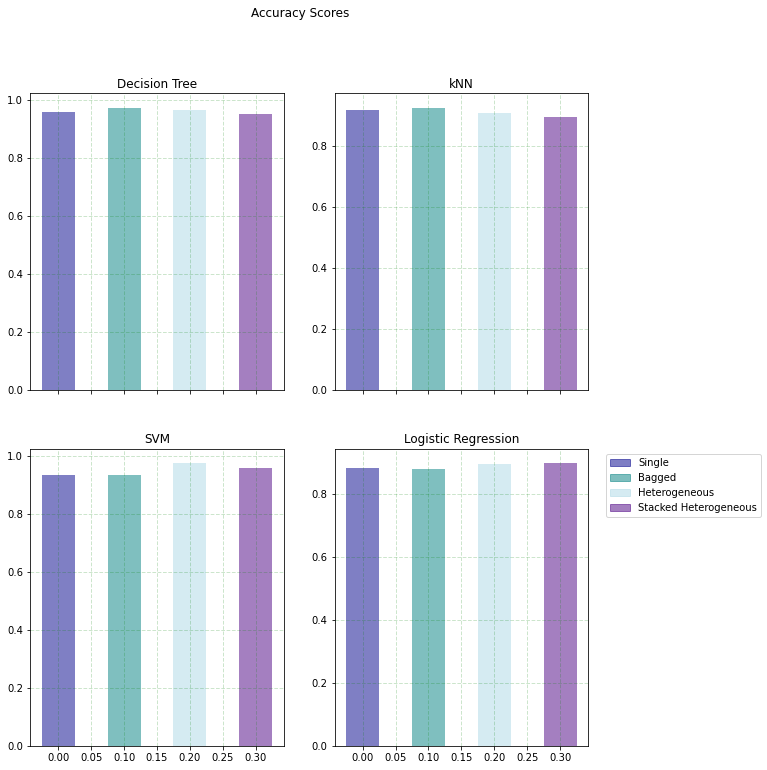

In [58]:
f, axs = plt.subplots(2, 2, figsize=(10,12), sharex=True)
plot_subplot(f, axs[0,0], "Decision Tree", benchmark_1['DTree'])
plot_subplot(f, axs[0,1], "kNN", benchmark_1['kNN'])
plot_subplot(f, axs[1,0], "SVM", benchmark_1['SVM'])
plot_subplot(f, axs[1,1], "Logistic Regression", benchmark_1['LR'])
b = mpatches.Patch(color='darkblue', alpha=0.5, label='Single')
y = mpatches.Patch(color='teal', alpha=0.5, label='Bagged')
g = mpatches.Patch(color='lightblue', alpha=0.5, label='Heterogeneous')
r = mpatches.Patch(color='indigo', alpha=0.5, label='Stacked Heterogeneous')
plt.legend(handles=[b,y,g,r], bbox_to_anchor=(1.05, 1), loc='upper left')
f.suptitle("Accuracy Scores")

- Globally the accuracy score is high, but the performance rankings are very changeable. Although the non-stacked heterogeneous ensemble is first overall in the average rankings, there is no obvious "winner". 
- For the decision tree, the stacked classifier has performed the worst, even worse than the single base classifier. The heterogeneous ensemble has come in second to the boosted classifier. 
- For kNN, the heterogeneous ensemble has perforformed the worst on this data, and the stacked hetereogeneous ensemble  and the stacked heterogeneous ensemble have performed poorly.
- For SVM both the heterogeneous ensemble and the stacked heterogeneous ensemble have performed very well, with the stacked heterogeneous ensemble performing slightly worse than the standard heterogeneous ensemble. 
- And for Logistic Regression we see a similar result, the two heterogeneous ensembles have performed the best, with the stacked model slightly outperforming the non-stacked model.



### Cross Validation

Given that holdout testing is done with a single "slice" of the data, it hard to discern whether the previous results are reliable our not. I would like to look further at the two classifiers where the ensembles performed poorly (Decision tree and Knn). In order to check the stability of these results, I will cross validate, while also varying the random seed. I am leaving the hyper paramater range unchanged. Given that the dataset is relatively balanced, I will be using accuracy as the principal measure of performance going forward.

In [45]:
reps, folds = 5, 10
folds = 10
benchmark_3 = pd.DataFrame(index = ['Single', 'Bagged', 'Ensemble', 'Stacked Ensemble'],
                           columns = ['Fold ' + str(i) for i in range(1,reps+1)])
for i in range (0, reps):
    kf = KFold(n_splits = folds, shuffle = True)
    clfs = [DecisionTreeClassifier(random_state =i+i),
            BaggingClassifier(base_estimator=copy(DecisionTreeClassifier(random_state = i+i)), random_state=i+i),
            HeterogenousEnsembleClassifier(base_estimator=DecisionTreeClassifier(random_state =i+i), hp_range_map=hparams['DTree'],random_state=i+i, verbosity=0),
            StackedHeterogenousEnsembleClassifier(base_estimator=DecisionTreeClassifier(random_state =i+i), hp_range_map=hparams['DTree'],random_state=i+i, verbosity=0)]
    results = []
    for c in clfs:
        xval = cross_val_score(c, X_train, y_train, cv=kf, scoring='accuracy', error_score="raise")
        results.append(xval.mean())
    benchmark_3['Fold '+str(i+1)] = results
        


In [46]:
benchmark_3

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
Single,0.956506,0.953639,0.957878,0.952544,0.959928
Bagged,0.972374,0.971417,0.974699,0.972236,0.975108
Ensemble,0.964715,0.963483,0.964170,0.963621,0.966493
Stacked Ensemble,0.942695,0.947348,0.944065,0.946388,0.940918


In [47]:
ranked_benchmark3 = benchmark_3.copy().rank(ascending=False)
ranked_benchmark3['average'] = ranked_benchmark3.mean(axis=1).rank()
ranked_benchmark3

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,average
Single,3.0,3.0,3.0,3.0,3.0,3.0
Bagged,1.0,1.0,1.0,1.0,1.0,1.0
Ensemble,2.0,2.0,2.0,2.0,2.0,2.0
Stacked Ensemble,4.0,4.0,4.0,4.0,4.0,4.0


The results here are extremely stable. For 5 repitions of 10 fold cross validation, with a different random state seed and shuffling of the data at each repition, the ranks have not varied. The stacked ensemble definitively does not perform well with a Decision Tree as a base classifier. This is very unusual, given that decision trees ususally respond well to ensembles. It is possible that the number of estimators is not sufficient, but given that the non-stacked heterogeneous ensemble is performing relatively well, that seems unlikely. It may be the combination of Decision Tree with SVM as the stack, that are not combining well together, or the data ratio. We will explore the effect of these hyperparameters later in testing.

In [48]:
reps, folds = 5, 10
benchmark_4 = pd.DataFrame(index = ['Single', 'Bagged', 'Ensemble', 'Stacked Ensemble'],
                           columns = ['Fold ' + str(i) for i in range(1,reps+1)])
for i in range (0, reps):
    kf = KFold(n_splits = folds, shuffle = True)
    clfs = [ KNeighborsClassifier() ,
            BaggingClassifier(base_estimator=KNeighborsClassifier(), random_state=i+i),
            HeterogenousEnsembleClassifier(base_estimator= KNeighborsClassifier(), hp_range_map=hparams['kNN'],random_state=i+i, verbosity=0),
            StackedHeterogenousEnsembleClassifier(base_estimator= KNeighborsClassifier() , hp_range_map=hparams['kNN'],random_state=i+i, verbosity=0)]
    results = []
    for c in clfs:
        xval = cross_val_score(c, X_train, y_train, cv=kf, scoring='accuracy', error_score="raise")
        results.append(xval.mean())
    benchmark_4['Fold '+str(i+1)] = results

In [49]:
benchmark_4

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
Single,0.919448,0.919992,0.918899,0.918489,0.920542
Bagged,0.920677,0.919581,0.921498,0.924644,0.922318
Ensemble,0.879787,0.926285,0.879924,0.858585,0.911786
Stacked Ensemble,0.870759,0.910016,0.856540,0.895101,0.885804


In [50]:
ranked_benchmark4 = benchmark_4.copy().rank(ascending=False)
ranked_benchmark4['average'] = ranked_benchmark4.mean(axis=1).rank()
ranked_benchmark4

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,average
Single,2.0,2.0,2.0,2.0,2.0,2.0
Bagged,1.0,3.0,1.0,1.0,1.0,1.0
Ensemble,3.0,1.0,3.0,4.0,3.0,3.0
Stacked Ensemble,4.0,4.0,4.0,3.0,4.0,4.0


The heterogeneous ensembles are performing poorly fairly consistently with kNN as a base classifier. kNN often does not respond work well in ensembles asit is quite a stable classifier. I was hoping that the varying of the "k" number would produce enough diversity to see gains in performance, but this has not occured. The bagged classifier is clearly performing the best here.

*For the testing that follows, I will be using SVM as our base classifier, as both the stacked and non stacked ensemble performed well with this base classifier, as seen below. As SVM is much more computationally heavy to run, I have reduced the crossval folds to 5.*

In [51]:
reps, folds = 5, 5
benchmark_5 = pd.DataFrame(index = ['Single', 'Bagged', 'Ensemble', 'Stacked Ensemble'],
                           columns = ['Fold ' + str(i) for i in range(1,reps+1)])
for i in range (0, reps):
    kf = KFold(n_splits = folds, shuffle = True)
    clfs = [svm.SVC(random_state=i+i) ,
            BaggingClassifier(base_estimator=svm.SVC(random_state=i+i), random_state=i+i),
            HeterogenousEnsembleClassifier(base_estimator= svm.SVC(random_state=i+i), hp_range_map=hparams['SVM'],random_state=i+i, verbosity=0),
            StackedHeterogenousEnsembleClassifier(base_estimator= svm.SVC(random_state=i+i) , hp_range_map=hparams['SVM'],random_state=i+i, verbosity=0)]
    results = []
    for c in clfs:
        xval = cross_val_score(c, X_train, y_train, cv=kf, scoring='accuracy', error_score="raise")
        results.append(xval.mean())
    benchmark_5['Fold '+str(i+1)] = results

In [52]:
benchmark_5

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
Single,0.925191,0.925054,0.923959,0.921362,0.923962
Bagged,0.924507,0.920406,0.920814,0.921227,0.922731
Ensemble,0.977844,0.944612,0.972237,0.796202,0.948438
Stacked Ensemble,0.961160,0.960887,0.963212,0.949262,0.946663


In [53]:
ranked_benchmark5 = benchmark_5.copy().rank(ascending=False)
ranked_benchmark5['average'] = ranked_benchmark5.mean(axis=1).rank()
ranked_benchmark5

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,average
Single,3.0,3.0,3.0,2.0,3.0,3.0
Bagged,4.0,4.0,4.0,3.0,4.0,4.0
Ensemble,1.0,2.0,1.0,4.0,1.0,2.0
Stacked Ensemble,2.0,1.0,2.0,1.0,2.0,1.0


Here we can see that although the stacked ensemble has the best overall ranking, first and second place in the rankings tends to alternate between the stacked and non-stacked heterogeneous classifier. Overall, in terms of accuracy, both heterogeneous ensemble implementations are performing well with SVM.

### Testing effect of "N" for n-classifiers

Next I would like to consider the effect of n-classifier number on accuracy. Here we will again use a holdout set instead of cross validation, and see how the classifier performs both in terms of accuracy and F1 score. As a base line we will compare it in accuracy to the performance of a a single base classifer, and a bootstrapped classifier. The random state will not be varied, but will be uniform for all classifiers . 

In [55]:
clf = svm.SVC(random_state=r).fit(X_train, y_train)
clf2 = BaggingClassifier(base_estimator=clf, random_state=r).fit(X_train, y_train)
y_pred = clf.predict(X_valid)
sv_base_acc = accuracy_score(y_pred, y_valid)
sv_base_f1 = f1_score(y_pred, y_valid, average='macro')
y_pred = clf2.predict(X_valid)
sv_boost_acc = accuracy_score(y_pred, y_valid)
sv_boost_f1 = f1_score(y_pred, y_valid, average='macro')

sv_acc, sv_f1, sv_stack_acc, sv_stack_f1 = [], [], [], []
n_range = [5, 10, 20, 30, 50, 100]
for n in n_range:
    print('Predicting for n = ', n)
    clf3 = HeterogenousEnsembleClassifier(clf, hp_range_map=hparams['SVM'], n_estimators=n, random_state=r)
    clf3.fit(X_train, y_train)
    y_pred = clf3.predict(X_valid)
    sv_acc.append(accuracy_score(y_pred, y_valid))
    sv_f1.append(f1_score(y_pred, y_valid, average='macro'))
    clf4 = StackedHeterogenousEnsembleClassifier(base_estimator=clf, hp_range_map=hparams['SVM'], n_estimators=n, random_state=r)
    clf4.fit(X_train, y_train)
    y_pred = clf4.predict(X_valid)
    sv_stack_acc.append(accuracy_score(y_pred, y_valid))
    sv_stack_f1.append(f1_score(y_pred, y_valid, average='macro'))




Predicting for n =  5
Predicting for n =  10
Predicting for n =  20
Predicting for n =  30
Predicting for n =  50
Predicting for n =  100


Text(0.5, 1.0, 'F1 Scores')

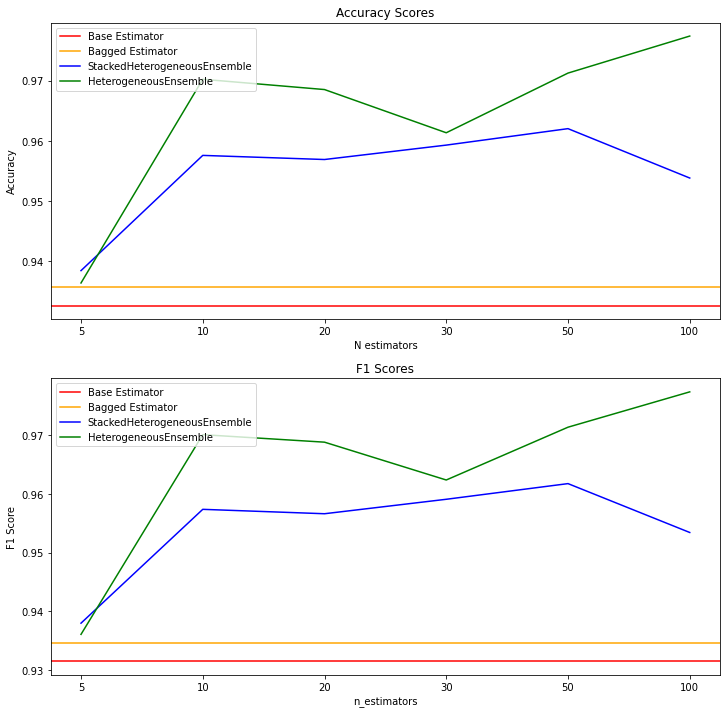

In [56]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
x = list(range(0,len(n_range)))
ax1.axhline(y=sv_base_acc, color='red', label='Base Estimator')
ax1.axhline(y=sv_boost_acc, color='orange', label='Bagged Estimator')
ax1.plot(x, sv_stack_acc, label="StackedHeterogeneousEnsemble", color="blue")
ax1.plot(x, sv_acc, label="HeterogeneousEnsemble", color="green")
ax1.legend(loc='upper left')
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy Scores")
ax1.set_xticklabels([0] + n_range)
ax1.set_xlabel("N estimators")

ax2.axhline(y=sv_base_f1, color='red', label='Base Estimator')
ax2.axhline(y=sv_boost_f1, color='orange', label='Bagged Estimator')
ax2.plot(x, sv_stack_f1, label="StackedHeterogeneousEnsemble", color="blue")
ax2.plot(x, sv_f1, label="HeterogeneousEnsemble", color="green")
ax2.legend(loc='upper left')
ax2.set_ylabel("F1 Score")
ax2.set_xlabel("n_estimators")
ax2.set_xticklabels([0] + n_range)

f.set_xticklabels = n_range
ax2.set_title("F1 Scores")

Interestingly, the rates of growth for the heterogeneous and stacked heterogeneous ensemble are quite different. We can see that the stacked heterogeneous ensemble is rarely even close to the accuracy of the non-stacked model. There is a point also (around n=50) where the accuracy of the stacked model starts to decrease, while the non-stacked model continues to increase. 

### Testing Varying Base Classifiers for Stack Layer

I am curious if this drop off in accuracy will be visible no matter the base classifier for the stacked model. I decided to next investigate performance of differing base estimators for the stack. For a baseline, I will compare performance against the non-heterogeneous classifier. N will be set to 30, as that is where accuracy started to diverge in the previous experiment.

In [61]:
r=1
clf = HeterogenousEnsembleClassifier(svm.SVC(random_state=r), hp_range_map=hparams['SVM'], n_estimators=30, random_state=r)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
base_acc_30 = accuracy_score(y_pred, y_valid)
clf = HeterogenousEnsembleClassifier(svm.SVC(random_state=r), hp_range_map=hparams['SVM'], n_estimators=10, random_state=r)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
base_acc_10 = accuracy_score(y_pred, y_valid)
acc, acc2 = [], []
for m in models:
    print("Now predicting ", m)
    clf = StackedHeterogenousEnsembleClassifier(base_estimator=svm.SVC(random_state=r), hp_range_map=hparams['SVM'], n_estimators=30, random_state=r, stack_layer_estimator=copy(models[m]))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    acc.append(accuracy_score(y_pred, y_valid))
    clf = StackedHeterogenousEnsembleClassifier(base_estimator=svm.SVC(random_state=r), hp_range_map=hparams['SVM'], n_estimators=10, random_state=r, stack_layer_estimator=copy(models[m]))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    acc2.append(accuracy_score(y_pred, y_valid))



Now predicting  DTree
Now predicting  kNN
Now predicting  SVM
Now predicting  LR


Text(0.5, 0.98, 'Accuracy of Varying Classifiers for Stack')

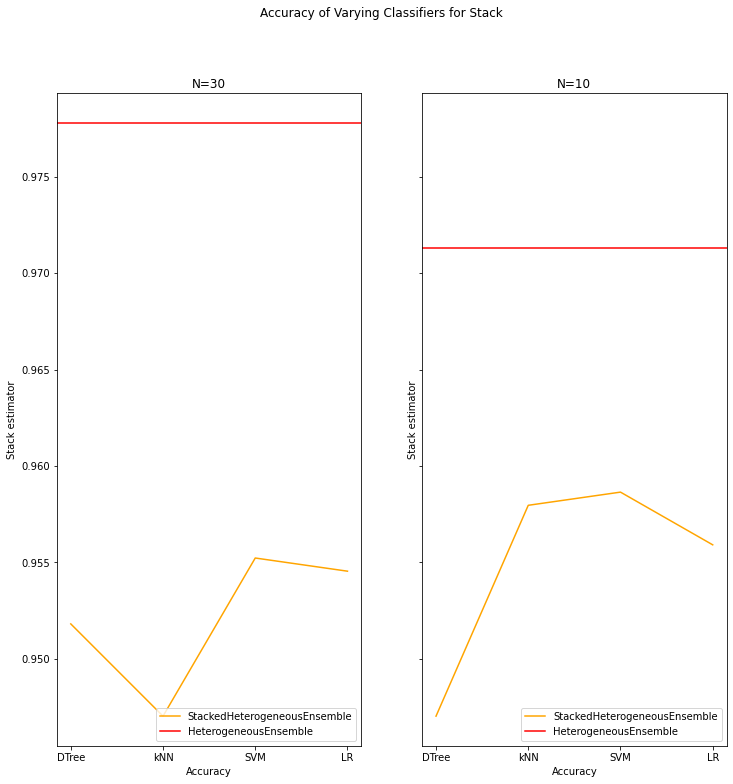

In [62]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12), sharey=True)
x = list(range(0,len(models)))
ax1.plot(x, acc, label="StackedHeterogeneousEnsemble", color="orange")
ax1.axhline(y=base_acc_30, color='red', label='HeterogeneousEnsemble')
ax1.legend(loc='lower right')
ax1.set_title("N=30")
ax1.set_xticks(list(range(0, len(models))))
ax1.set_xticklabels([m for m in models])
ax1.set_xlabel("Accuracy")
ax1.set_ylabel("Stack estimator")

ax2.plot(x, acc2, label="StackedHeterogeneousEnsemble", color="orange")
ax2.axhline(y=base_acc_10, color='red', label='HeterogeneousEnsemble')
ax2.legend(loc='lower right')
ax2.set_title("N=10")
ax2.set_xticks(list(range(0, len(models))))
ax2.set_xticklabels([m for m in models])
ax2.set_xlabel("Accuracy")
ax2.set_ylabel("Stack estimator")

f.suptitle("Accuracy of Varying Classifiers for Stack")

We can see that performance does vary quite a bit depending on the base classifier, and that in generaly the stacked ensemble performs best with n=10, although here it is not nearly meeting the performance of the heterogeneous ensemble.

### Testing the data ratio

I am curious to see if varying the data ratio to the stack will effect performance. We will test a range of values, while keeping n=10.

In [63]:
acc = []
ratio = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for r in ratio:
    clf = StackedHeterogenousEnsembleClassifier(base_estimator=svm.SVC(random_state=1), 
                                                hp_range_map=hparams['SVM'], n_estimators=10, 
                                                random_state=0, stack_layer_estimator=copy(models['LR']), 
                                                base_stack_data_ratio = r)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    acc.append(accuracy_score(y_pred, y_valid))




Text(0, 0.5, 'base_stack_data_ratio')

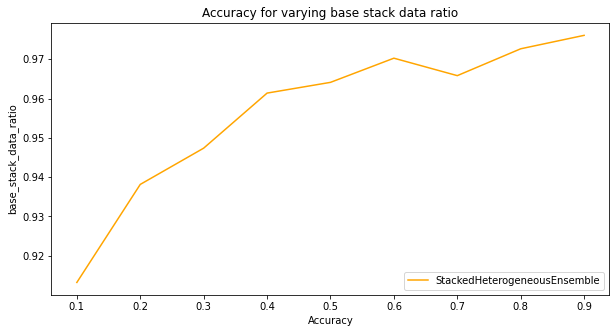

In [64]:
f, ax1 = plt.subplots(1, 1, figsize=(10,5), sharex=True)
x = list(range(0,len(ratio)))
ax1.plot(x, acc, label="StackedHeterogeneousEnsemble", color="orange")
ax1.legend(loc='lower right')
ax1.set_title("Accuracy for varying base stack data ratio")
ax1.set_xticks(list(range(0, len(ratio))))
ax1.set_xticklabels(ratio)
ax1.set_xlabel("Accuracy")
ax1.set_ylabel("base_stack_data_ratio")

There are two peaks here, for ratio = 0.6, and ratio = 0.9. One imagines that a ratio of 0.9 would surely lead to underfitting of the stack estimator, I will cross validate to see if this holds.

In [89]:
reps, folds = 5, 5
acc1,acc2 = [], []
for i in range (0, reps):
    kf = KFold(n_splits = folds, shuffle = True)
    clf1 = StackedHeterogenousEnsembleClassifier(base_estimator=svm.SVC(random_state=42), 
                                                hp_range_map=hparams['SVM'], n_estimators=10, 
                                                random_state=0, stack_layer_estimator=copy(models['LR']), 
                                                base_stack_data_ratio = .6)
    clf2 = StackedHeterogenousEnsembleClassifier(base_estimator=svm.SVC(random_state=42), 
                                                hp_range_map=hparams['SVM'], n_estimators=10, 
                                                random_state=0, stack_layer_estimator=copy(models['LR']), 
                                                base_stack_data_ratio = .9)
    acc1.append(cross_val_score(clf1, X_train, y_train, cv=kf, scoring='accuracy', error_score="raise").mean())
    acc2.append(cross_val_score(clf2, X_train, y_train, cv=kf, scoring='accuracy', error_score="raise").mean())


Text(0, 0.5, 'Folds')

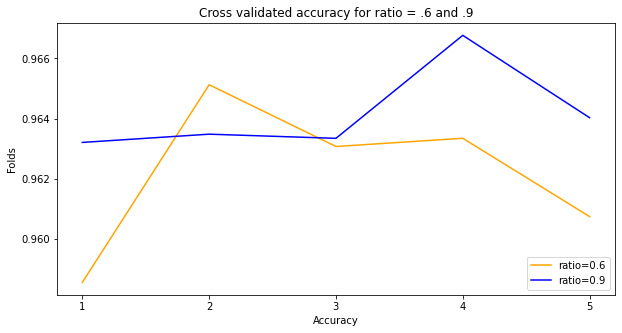

In [91]:
f, ax1 = plt.subplots(1, 1, figsize=(10,5), sharex=True)
x = list(range(1,folds+1))
ax1.plot(x, acc1, label="ratio=0.6", color="orange")
ax1.plot(x, acc2, label="ratio=0.9", color="blue")
ax1.legend(loc='lower right')
ax1.set_title("Cross validated accuracy for ratio = .6 and .9")
ax1.set_xticks(list(range(1, folds+1)))
ax1.set_xlabel("Accuracy")
ax1.set_ylabel("Folds")

We can see the accuracy is quite changeable accross the folds. It is hard to discern which would be a better ratio, although .9 has the highest peak.

### Test Data

Given the knowledge garnered from the previous tests, I will now check performance on the test set. 
- For both the heterogeneous ensemble and the stacked ensemble I will use SVM as a base classifier.
- As accuracy seemed to increase as n increased for the heterogeneous ensemble, whereas it seemed to stagnate after n=20 for the stacked ensemble, I will set n=100 and n=20 respectively.
- For the stacked ensemble, I will set the data ratio to 0.9 and use SVM as the estimator for the stacked layer.

In [82]:
clf1 = StackedHeterogenousEnsembleClassifier(base_estimator=svm.SVC(random_state=1), 
                                                hp_range_map=hparams['SVM'], n_estimators=10, 
                                                random_state=1, stack_layer_estimator=copy(models['SVM']), 
                                                base_stack_data_ratio = .7)
clf2 = HeterogenousEnsembleClassifier(base_estimator=svm.SVC(random_state=1), 
                                                hp_range_map=hparams['SVM'], n_estimators=30, 
                                                random_state=3)
clf3 = svm.SVC(random_state=i+i)
clf4 = BaggingClassifier(base_estimator=svm.SVC(random_state=i+i), random_state=i+i)
clfs = [clf1,clf2,clf3,clf4]

In [83]:
benchmark_6 = pd.DataFrame(index = ['Stacked Ensemble','Ensemble','Single', 'Bagged'],
                          columns = ['Accuracy', 'F1'])
acc, f1, pred = [], [], []
for i, clf in enumerate(clfs):
    c.fit(X_train, y_train)
    pred.append(c.predict(X_test))
    acc.append(accuracy_score(pred[i], y_test))                      
    f1.append(f1_score(pred[i], y_test, average='macro'))
   

In [84]:
benchmark_6['Accuracy'] = acc
benchmark_6['F1'] = f1

In [85]:
benchmark_6

,Accuracy,F1
Stacked Ensemble,0.953292,0.953067
Ensemble,0.956482,0.956278
Single,0.953976,0.953971
Bagged,0.956710,0.956580


In [86]:
benchmark_6.rank(ascending=False)

,Accuracy,F1
Stacked Ensemble,4.0,4.0
Ensemble,2.0,2.0
Single,3.0,3.0
Bagged,1.0,1.0


In [87]:
print("Heterogeneous Ensemble on Test Data \n-----------------------\n")
print(metrics.classification_report(y_test, pred[1]))

Heterogeneous Ensemble on Test Data 
-----------------------

              precision    recall  f1-score   support

           1       0.95      0.98      0.97       425
           2       0.84      0.95      0.89       411
           3       0.97      1.00      0.98       393
           4       0.99      0.99      0.99       406
           5       0.96      0.94      0.95       393
           6       0.95      0.92      0.94       380
           7       1.00      1.00      1.00       395
           8       0.97      0.96      0.97       390
           9       0.99      0.95      0.97       401
          10       0.92      0.81      0.87       394
          11       1.00      1.00      1.00       401

    accuracy                           0.96      4389
   macro avg       0.96      0.96      0.96      4389
weighted avg       0.96      0.96      0.96      4389



In [88]:
print("Stacked Heterogeneous Ensemble On Test Data \n---------------------\n")
print(metrics.classification_report(y_test, pred[0]))

Stacked Heterogeneous Ensemble On Test Data 
---------------------

              precision    recall  f1-score   support

           1       0.94      0.98      0.96       425
           2       0.88      0.94      0.91       411
           3       0.99      0.98      0.99       393
           4       1.00      0.99      0.99       406
           5       0.92      0.94      0.93       393
           6       0.95      0.91      0.93       380
           7       1.00      1.00      1.00       395
           8       0.94      0.92      0.93       390
           9       0.96      0.97      0.96       401
          10       0.92      0.86      0.89       394
          11       1.00      1.00      1.00       401

    accuracy                           0.95      4389
   macro avg       0.95      0.95      0.95      4389
weighted avg       0.95      0.95      0.95      4389



([<matplotlib.axis.XTick at 0x7fa7697edd60>,
 [Text(0.0, 0, 'StackedHeterogeneousEnsembleClassifier'),
  Text(0.1, 0, 'HeterogeneousEnsembleClassifier'),
  Text(0.2, 0, 'Single Classifier'),
  Text(0.3, 0, 'Bagged Classifier')])

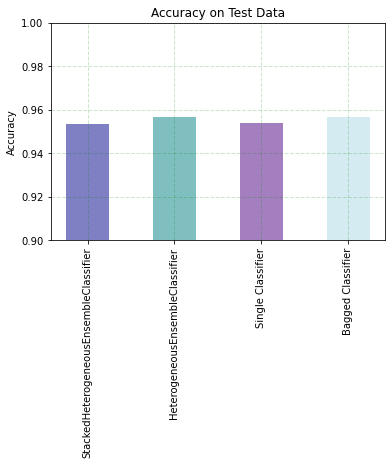

In [92]:
X = np.arange(1)
plt.grid(color='g', alpha = 0.2, linestyle='--', linewidth=1)
plt.bar(X + 0.00, acc[0], color = 'darkblue', alpha=0.5, width = 0.05)
plt.bar(X + 0.10, acc[1], color = 'teal', alpha=0.5, width = 0.05)
plt.bar(X + 0.20, acc[2], color = 'indigo', alpha=0.5, width = 0.05)
plt.bar(X + 0.30, acc[3], color = 'lightblue', alpha=0.5, width = 0.05)
plt.ylim(.9, 1.0)
plt.title("Accuracy on Test Data")
plt.ylabel("Accuracy")
plt.xticks(ticks=[0,0.1,0.2,0.3],
           rotation=90,
           labels=["StackedHeterogeneousEnsembleClassifier","HeterogeneousEnsembleClassifier","Single Classifier","Bagged Classifier"])

Overall performance is extremely close between all four classifiers, with even the untuned base classifier receiving an accuracy score of 95%, and the difference between first and last being less than 1%. Overall, the heterogeneous classifier has won out, with the stacked classifier performing the worst in this context.

## Task 4: Reflect on the Performance of the Different Models Evaluated

- Although it appears the stacked and non-stacked ensembles have a great gap in performance (ranked last and first respectively), when we look at the accuracy scores there is less than 1% difference. In general though, their performance has been inconsistent and during testing they were sometimes outperformed by the untuned boosted classifier or untuned base classifier.

- Over both classifiers can be computationally slow, although it must be noted their overall speed depends significantly on which base classifier is selected for use.

- The use of a cartesian join in the generation of parameter combinations vis computationally expensive. I have not been able to find a definitive source citing the complexity of the itertools.product package, but I imagine it would have to be at least O(k)^2, where k is the number of hyper-parameters given. I did not find a way to optimise this step while preserving a truly random selection of hyper-parameters, so I decided to sacrifice computational cost for performance. 

- The stacked classifier involves two extra computational steps; iterating through and 	transforming the ensemble predictions into a new dataset (both in the fit and the  predict stages), and training the stacked layer. Given that the stacked ensemble does not consistently outperform the non-stacked ensemble, these extra steps are difficult to justify.

- I do wonder if the data for the stacked classifier is falling foul of the curse of dimensionality, but am unsure how to test that hypothesis.

- The aggregation step in the non-stacked classifier could be computationally optimised by using a tool such as scipy.stats.mode. The issue with this package is that for multimodal data, it will always select the smaller number, which could potentially create a new bias in the data. E.g. If a number of queries had 50/50 splits between class 0 and class 1, class 0 would always predicted. Currently if there is a “draw” for the most frequent response, it is selected at random, but this verification is an extra computational step.

- Personally, in terms of code design, I would prefer to merge these two classifiers into one, where the stacked layer is an option to be turned on/off at initialisation. This would not have an effect on performance, but would reduce repeated code. 